# Proyecto - Airplane crashes since 1908
**Universidad de antioquia**
---
* Ingeniería de sistemas
* Semestre 2020 - 1
* Profesor Julian David Arias Londoño
---
Estudiantes
*   Nombre: Carlos Andres Gomez M. - Cédula: 1020416643
*   Nombre: Esteban Restrepo S. - Cédula: 1037650304

In [1]:
import itertools
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
import matplotlib.colors as colors
import seaborn as sns
import time
from collections import Counter
from gensim import corpora, models
from mlxtend.feature_selection import SequentialFeatureSelector
from scipy.spatial.distance import euclidean
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report,precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.svm import SVC


import plotly.offline as py
%matplotlib inline

from sklearn.metrics import confusion_matrix
import seaborn as sns

py.init_notebook_mode(connected=True)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Introducción y configuración


In [2]:
db = pd.read_csv('./Airplane_Crashes_and_Fatalities_Since_1908.csv')
print("DB set size:", db.shape)


DB set size: (5268, 13)


In [3]:
 100 * db.isnull().sum()/len(db)

Date             0.000000
Time            42.122248
Location         0.379651
Operator         0.341686
Flight #        79.707669
Route           32.384207
Type             0.512528
Registration     6.359150
cn/In           23.310554
Aboard           0.417616
Fatalities       0.227790
Ground           0.417616
Summary          7.403189
dtype: float64



*   Time - Alto porcentaje de valores faltantes
*   Flight # - Alto porcentaje de valores faltantes
*   Route - Alto porcentaje de valores faltantes
*   Registration - Alto porcentaje de valores faltantes
*   Summary - Alto porcentaje de valores faltantes
*   cn/In - Alto porcentaje de valores faltantes
*   Date -  Irrelevante para este proyecto
*   Ground - Irrelevante para este proyecto



In [4]:
del db["Time"]
del db["Flight #"]
del db["Route"]
del db["cn/In"]
del db["Registration"]
del db["Ground"]
del db['Date']
del db["Summary"]

In [5]:
def removeAboardNaN(row):
  """funcion que sobrescribe los valores NAN en la columna Aboard
  """
  if np.isnan(row.Aboard):
      if np.isnan(row.Fatalities):
        return 1.0
      else:
        return row.Fatalities
  else: 
    return row.Aboard

def removeFatalitiesNaN(row):
  """funcion que sobrescribe los valores NAN en la columna Fatalities
  """
  if np.isnan(row.Fatalities):
        return row.Aboard
  else:
    return row.Fatalities

db['Aboard'] = db.apply(removeAboardNaN, axis=1)
db['Fatalities'] = db.apply(removeFatalitiesNaN, axis=1)
def get_percentage(x):
  """ Funcion que calcula el porcentaje de fatalidad del accidente teniendo en cuenta ciertos parametros
  """
  if x.Aboard != 0.0:
    return (x.Fatalities*100)/x.Aboard
  else: 
    return 0.0

db['Fatality_Level'] = db.apply(get_percentage, axis=1)
db.describe()

,Aboard,Fatalities,Fatality_Level
count,5268.000000,5268.000000,5268.000000
mean,27.464692,20.024867,83.530397
std,43.024590,33.174570,29.872367
min,0.000000,0.000000,0.000000
25%,5.000000,3.000000,80.851064
50%,13.000000,9.000000,100.000000
75%,30.000000,23.000000,100.000000
max,644.000000,583.000000,100.000000


In [ ]:

oper_list = Counter(db['Operator']).most_common(20)
operators = []
crashes = []
for tpl in oper_list:
    if 'Military' not in tpl[0]:
        operators.append(tpl[0])
        crashes.append(tpl[1])
print('Top 10 de los peores operadores')
pd.DataFrame({'Número de accidentes' : crashes}, index=operators)

Top 10 de los peores operadores


,Número de accidentes
Aeroflot,179
Air France,70
Deutsche Lufthansa,65
China National Aviation Corporation,44
United Air Lines,44
Air Taxi,44
Pan American World Airways,41
US Aerial Mail Service,36
American Airlines,36
Indian Airlines,34


In [ ]:
loc_list = Counter(db['Location'].dropna()).most_common(15)
locs = []
crashes = []
for loc in loc_list:
    locs.append(loc[0])
    crashes.append(loc[1])
print('Top 15 de los lugares más peligrosos')
pd.DataFrame({'Accidentes en este lugar' : crashes}, index=locs)

Top 15 de los lugares más peligrosos


,Accidentes en este lugar
"Sao Paulo, Brazil",15
"Moscow, Russia",15
"Rio de Janeiro, Brazil",14
"Bogota, Colombia",13
"Manila, Philippines",13
"Anchorage, Alaska",13
"New York, New York",12
"Cairo, Egypt",12
"Chicago, Illinois",11
"Near Moscow, Russia",9


In [7]:
def make_series_dataset(ds,columnName, n_steps_lookback):
    """Funcion para crear un dataset con base en los niveles de fatalidad para proceder a realizar un problema de clasificacion
    """
    keys_values = {}
    for x in range(n_steps_lookback):
      keys_values[columnName+'_'+str(x)] = ds[columnName].shift(-x)
    r = pd.DataFrame(keys_values)
    r = r.join(ds[columnName].shift(-n_steps_lookback))
    r = r.dropna()
    return r

dt = make_series_dataset(db, columnName="Fatality_Level", n_steps_lookback=10)

# #cargamos la base de datos

X, y = dt[[i for i in dt.columns if i!="Fatality_Level"]].values, dt.Fatality_Level.values

y = (y>X[:,:].mean(axis=1)).astype(int)

print ("1's en y  %.2f%s"%(np.mean(y)*100, "%"))

dfBest = pd.DataFrame(np.zeros((5, 6)),columns=['error/eficiencia de prueba', 'desviacion estandar prueba', 'accurancy real','precision score','recall score','f1 score'], index=["QDA","Parzen","GBT","MLPC","SVC"])

1's en y  72.02%


In [ ]:
dt

,Fatality_Level_0,Fatality_Level_1,Fatality_Level_2,Fatality_Level_3,Fatality_Level_4,Fatality_Level_5,Fatality_Level_6,Fatality_Level_7,Fatality_Level_8,Fatality_Level_9,Fatality_Level
0,50.000000,100.000000,100.000000,70.000000,100.000000,51.219512,100.000000,100.000000,100.000000,100.000000,96.428571
1,100.000000,100.000000,70.000000,100.000000,51.219512,100.000000,100.000000,100.000000,100.000000,96.428571,100.000000
2,100.000000,70.000000,100.000000,51.219512,100.000000,100.000000,100.000000,100.000000,96.428571,100.000000,100.000000
3,70.000000,100.000000,51.219512,100.000000,100.000000,100.000000,100.000000,96.428571,100.000000,100.000000,100.000000
4,100.000000,51.219512,100.000000,100.000000,100.000000,100.000000,96.428571,100.000000,100.000000,100.000000,100.000000
...,...,...,...,...,...,...,...,...,...,...,...
5253,94.444444,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,9.090909,100.000000,100.000000,87.500000
5254,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,9.090909,100.000000,100.000000,87.500000,100.000000
5255,100.000000,100.000000,100.000000,100.000000,100.000000,9.090909,100.000000,100.000000,87.500000,100.000000,100.000000
5256,100.000000,100.000000,100.000000,100.000000,9.090909,100.000000,100.000000,87.500000,100.000000,100.000000,100.000000


# Análisis discriminante Cuadrático

In [10]:

def experimentarQDA(X, y, params_reg, tol):
  """funcion que realiza analisis discriminante cuadratico
    X: matriz con las caractersiticas
    Y: matriz de numpy con etiquetas

    retorna
    """
  idx = 0
  kf = StratifiedKFold(n_splits=4)
  resultados = pd.DataFrame()
  tol_regs = list(itertools.product(tol, params_reg))
  
  for params in tol_regs:
    tol, param_reg = params
    pct_support_vectors = []
    ErrorTrain = []
    ErrorTest = []
    MACC = []
    MPRE = []
    MREC = []
    MF1 = []
    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf = QuadraticDiscriminantAnalysis(priors=None, reg_param=param_reg, tol=tol)
        clf.fit(X_train, y_train)

        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)

        #errres y pct de vectores de soporte
        ErrorTrain.append(accuracy_score(y_true = y_train, y_pred = y_train_pred))
        ErrorTest.append(accuracy_score(y_true = y_test, y_pred = y_test_pred))
        #contar muestras de entrenamiento
        MACC.append(accuracy_score(y_true = y_train, y_pred = y_train_pred))
        MPRE.append(precision_score(y_true = y_test, y_pred = y_test_pred))
        MREC.append(recall_score(y_true = y_test, y_pred = y_test_pred))
        MF1.append(f1_score(y_test, y_test_pred))
    # clear_output(wait=True)
    resultados.loc[idx,'param_reg'] = param_reg
    resultados.loc[idx,'tol'] = tol
    resultados.loc[idx,'error/eficiencia de entrenamiento'] = np.mean(ErrorTrain)
    resultados.loc[idx,'desviacion estandar entrenamiento'] = np.std(ErrorTrain)
    resultados.loc[idx,'error/eficiencia de prueba'] = np.mean(ErrorTest)
    resultados.loc[idx,'desviacion estandar prueba'] = np.std(ErrorTest)
    resultados.loc[idx,'accurancy real'] = np.mean(MACC)
    resultados.loc[idx,'precision score'] = np.mean(MPRE)
    resultados.loc[idx,'recall score'] = np.mean(MREC)
    resultados.loc[idx,'f1 score'] = np.mean(MF1)
    idx= idx +1
  return (resultados, resultados.iloc[[resultados["f1 score"].idxmax()],4:].to_numpy())

In [ ]:
params_reg=[0.001,0.01,0.1,0.2,0.3,0.4,0.5,1]
tol=[1]
experimentarQDA_DF, mejorQda = experimentarQDA(X, y, params_reg, tol)
dfBest.iloc[0] = mejorQda[0]
experimentarQDA_DF

,param_reg,tol,error/eficiencia de entrenamiento,desviacion estandar entrenamiento,error/eficiencia de prueba,desviacion estandar prueba,accurancy real,precision score,recall score,f1 score
0,0.001,1.0,0.698175,0.003658,0.696652,0.003656,0.698175,0.739873,0.894122,0.809243
1,0.010,1.0,0.697858,0.004015,0.696652,0.003411,0.697858,0.740185,0.893330,0.809085
2,0.100,1.0,0.694751,0.002726,0.696462,0.003919,0.694751,0.741305,0.890162,0.808400
3,0.200,1.0,0.692469,0.003868,0.693990,0.004000,0.692469,0.741671,0.884090,0.806051
4,0.300,1.0,0.689806,0.002700,0.691138,0.006504,0.689806,0.742185,0.876961,0.803187
5,0.400,1.0,0.687270,0.001836,0.689237,0.007858,0.687270,0.742325,0.872473,0.801358
6,0.500,1.0,0.686319,0.002093,0.685815,0.010776,0.686319,0.741925,0.866137,0.798319
7,1.000,1.0,0.546152,0.003021,0.537862,0.053441,0.546152,0.761860,0.522876,0.612104


# Ventana de Parzen (Metodo kernel) 


In [ ]:
def errorClas(Y_lest, Y):
    """funcion que calcula el error de clasificación
    Y_lest: numpy array con la estimaciones de etiqueta
    Y: etiquetas reales
    retorna: error de clasificación (int)
    """
    error = 1 - np.sum(Y_lest == Y)/len(Y)
    
    return error

def kernel_gaussiano(x):
    """Calcula el kernel gaussiano de x
    x: matriz/vector de numpy
    retorna: el valor de de kernel gaussiano
    """
    return np.exp((-0.5)*x**2)

def parzenWindow(x,Data,h):
    """"ventana de parzen
    x: vector con representando una sola muestra
    Data: vector de muestras de entrenamiento
    h: ancho de la ventana de kernel
    retorna: el valor de ventana de parzen para una muestra
    """
    h = h
    Ns = Data.shape[0]
    suma = 0
    for k in range(Ns):
        u = euclidean(x,Data[k,:])
        suma += kernel_gaussiano(u/h)
    return suma

def parzenClass(X_train, Y_train, X_test, h):
    """ Funcion que implementa metodo de ventana de parzen para
        para clasificación
    X_train: es la matriz con las muestras de entrenamiento
    Y_train: es un vector con los valores de salida pra cada una de las muestras de entrenamiento
    X_test: es la matriz con las muestras de validación
    h (float): ancho de h de la ventana
    retorna: - las estimaciones del modelo parzen para el conjunto X_test 
              esta matriz debe tener un shape de [row/muestras de X_test]
             - las probabilidades de la vetana [row/muestras de X_test, numero de clases]  
    """
    Yest = np.zeros(X_test.shape[0])
    clases = np.unique(Y_train)
    fds_matrix = np.zeros((X_test.shape[0], len(clases)))

    for n, sample in enumerate (X_test):
      valueFdp = []
      arrayValuesClass = []
      for label in clases:
        arrayValuesClass.append(X_train[Y_train == clases[label]])
        fds_matrix[n, label] = parzenWindow(X_test[n], arrayValuesClass[label], h) / (len(arrayValuesClass[label]))
        valueFdp.append(fds_matrix[n,label])
        
      Yest[n] = valueFdp.index(max(valueFdp))
    
    return Yest, fds_matrix

In [ ]:

def experimentarParzen (X, Y, ks):
    
    """Función que realiza los experimentos con knn usando
       una estrategia de validacion entrenamiento y pruebas
    X: matriz de numpy conjunto con muestras y caracteristicas
    Y: vector de numpy con los valores de las etiquetas
    ks: List[int/float] lista con los valores de k-vecinos a usar
    retorna: dataframe con los resultados, debe contener las siguientes columnas:
        - el ancho de ventana, el error medio de prueba, la desviacion estandar del error
    """
    
    skf = StratifiedKFold(n_splits=4)
    resultados = pd.DataFrame()
    idx = 0
    # iteramos sobre los valores de ks
    for k in ks:
        # lista para almacenar los errores de cada iteración
        ErrorTest = []
        MACC = []
        MPRE = []
        MREC = []
        MF1 = []
        for train, test in skf.split(X, Y):
            
            x_train = X[train,:]
            y_train = Y[train]
            x_test = X[test,:]
            y_test = Y[test]
            
            y_test_pred, probabilidades = parzenClass(x_train, y_train, x_test, k)

            ErrorTest.append(errorClas(y_test_pred, y_test))
            #contar muestras de entrenamiento
            MACC.append(accuracy_score(y_true = y_test, y_pred = y_test_pred))
            MPRE.append(precision_score(y_true = y_test, y_pred = y_test_pred))
            MREC.append(recall_score(y_true = y_test, y_pred = y_test_pred))
            MF1.append(f1_score(y_test, y_test_pred))

        
        resultados.loc[idx,'ancho de ventana'] = k 
        resultados.loc[idx,'error/eficiencia de prueba'] = np.mean(ErrorTest)
        resultados.loc[idx,'desviación estandar prueba'] = np.std(ErrorTest)
        resultados.loc[idx,'accurancy real'] = np.mean(MACC)
        resultados.loc[idx,'precision score'] = np.mean(MPRE)
        resultados.loc[idx,'recall score'] = np.mean(MREC)
        resultados.loc[idx,'f1 score'] = np.mean(MF1)
        idx+=1
    return (resultados, resultados.iloc[[resultados["f1 score"].idxmax()],1:].to_numpy())

In [ ]:
experimentarParzen_DF, mejorParzen = experimentarParzen(X, y, ks=[1,2,3,4])
dfBest.iloc[1] = mejorParzen[0]
experimentarParzen_DF

,ancho de ventana,error/eficiencia de prueba,desviación estandar prueba,accurancy real,precision score,recall score,f1 score
0,1.0,0.458736,0.021675,0.541264,0.726210,0.582509,0.646366
1,2.0,0.393683,0.008422,0.606317,0.739537,0.700560,0.719226
2,3.0,0.396917,0.009089,0.603083,0.742065,0.688941,0.714182
3,4.0,0.402052,0.006449,0.597948,0.744306,0.673888,0.706997


# Gradient Boosting Tree

In [13]:
def experimentar_gbt(num_trees, X, Y):
    """funcion que realiza experimentos de arboles de decision
    num_trees: list[int] lista con el número de arboles usado para el RF
    X: matriz con las caractersiticas
    Y: matriz de numpy con etiquetas
    retorna: dataframe con:
        - numero de arboles usados
        - eficiencia de entrenamiento
        - desviacion de estandar eficiencia de entrenamiento
        - eficiencia de prueba
        - desviacion estandar eficiencia de prueba
    """
    folds = 4
    skf = StratifiedKFold(n_splits=folds)
    resultados = pd.DataFrame()
    idx = 0
    for trees in num_trees:
        ## para almacenar los errores intermedios
        ErrorTrain = []
        ErrorTest = []
        MACC = []
        MPRE = []
        MREC = []
        MF1 = []
        for train, test in skf.split(X, Y):
            x_train = X[train,:]
            y_train = Y[train]
            x_test = X[test,:]
            y_test = Y[test]
            
            modelo = GradientBoostingClassifier(n_estimators = trees)
            modelo = modelo.fit(x_train, y_train)
            #predecir muestras de entrenamiento
            y_train_pred = modelo.predict(x_train) 
            #predecir muestras de pruebas
            y_test_pred = modelo.predict(x_test)

            #errores y pct de vectores de soporte
            ErrorTrain.append(accuracy_score(y_true = y_train, y_pred = y_train_pred))
            ErrorTest.append(accuracy_score(y_true = y_test, y_pred = y_test_pred))
            #contar muestras de entrenamiento
            MACC.append(accuracy_score(y_true = y_train, y_pred = y_train_pred))
            MPRE.append(precision_score(y_true = y_test, y_pred = y_test_pred))
            MREC.append(recall_score(y_true = y_test, y_pred = y_test_pred))
            MF1.append(f1_score(y_test, y_test_pred))

        resultados.loc[idx,'número de arboles'] = trees
        resultados.loc[idx,'error/eficiencia de entrenamiento'] = np.mean(ErrorTrain)
        resultados.loc[idx,'desviacion estandar entrenamiento'] = np.std(ErrorTrain)
        resultados.loc[idx,'error/eficiencia de prueba'] = np.mean(ErrorTest)
        resultados.loc[idx,'desviacion estandar prueba'] = np.std(ErrorTest)
        resultados.loc[idx,'accurancy real'] = np.mean(MACC)
        resultados.loc[idx,'precision score'] = np.mean(MPRE)
        resultados.loc[idx,'recall score'] = np.mean(MREC)
        resultados.loc[idx,'f1 score'] = np.mean(MF1)
        idx= idx +1
        
    return (resultados,resultados.iloc[[resultados["f1 score"].idxmax()],3:].to_numpy())

In [ ]:
num_trees= [5,10,20,50,100,200,500,1000,2000,5000]

experimentar_gbt_DF, mejorGBT = experimentar_gbt(num_trees, X, y)
dfBest.iloc[2] = mejorGBT[0]
experimentar_gbt_DF

,número de arboles,error/eficiencia de entrenamiento,desviacion estandar entrenamiento,error/eficiencia de prueba,desviacion estandar prueba,accurancy real,precision score,recall score,f1 score
0,5.0,0.720553,0.000611,0.719665,0.001181,0.720553,0.720243,0.998679,0.836909
1,10.0,0.720680,0.000829,0.719665,0.001181,0.720680,0.720328,0.998414,0.836873
2,20.0,0.720870,0.001020,0.719475,0.001148,0.720870,0.720274,0.998150,0.836744
3,50.0,0.723089,0.000835,0.718524,0.001511,0.723089,0.720007,0.996830,0.836099
4,100.0,0.731330,0.000699,0.713960,0.003916,0.731330,0.718886,0.989965,0.832920
5,200.0,0.752377,0.000842,0.711868,0.005644,0.752377,0.721015,0.978611,0.830279
6,500.0,0.821161,0.010626,0.696272,0.003126,0.821161,0.722271,0.939791,0.816721
7,1000.0,0.890515,0.007237,0.682770,0.005331,0.890515,0.726549,0.897542,0.802976
8,2000.0,0.953848,0.002648,0.672497,0.017957,0.953848,0.736600,0.849221,0.788870
9,5000.0,0.987575,0.002713,0.649486,0.011566,0.987575,0.735169,0.802746,0.767422


# Redes Neuronales Artificiales 


In [ ]:
def experimetar_mlpc(X,Y, num_hidden_layers, num_neurons):
    """ función para realizar experimentos con el MLP
    x: matriz de numpy con caracteristicas
    y: vector numpy con las variables a predecir
    num_hidden_layers: list de enteros con el numero de capdas
        ocultas a usar
    num_neurons: list de enteros con el numero de neuronas a usar
    
    Retorna: dataframe con 4 columnas:
        - numero de capas, numero de neuronas
        - promedio de error prueba (exactitud/eficiencia) de claisficacion y desviación estandar        
    """
    Folds = 4
    skf = StratifiedKFold(n_splits=Folds)
    resultados = pd.DataFrame()
    idx = 0
    for hidden_layers in num_hidden_layers:
        for neurons in num_neurons:
            for j, (train, test) in enumerate(skf.split(X, Y)):
                # para almacenar errores intermedios
                ErrorTrain = np.zeros(Folds)
                ErrorTest = np.zeros(Folds)
                MACC = np.zeros(Folds)
                MPRE = np.zeros(Folds)
                MREC = np.zeros(Folds)
                MF1 = np.zeros(Folds)

                x_train= X[train,:]
                y_train = Y[train]
                x_test = X[test, :]
                y_test = Y[test]
              
                hidden_layer_sizes = tuple(hidden_layers*[neurons])
                
                mlp = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes, activation='tanh', max_iter=400)
                # entrenar el MLP
                mlp = mlp.fit(X=x_train,y=y_train)
                #Use para el modelo para hacer predicciones sobre el conjunto x_test
                y_train_pred = mlp.predict(x_train)
                y_test_pred = mlp.predict(x_test)

                ErrorTrain[j] = accuracy_score(y_true=y_train, y_pred=y_train_pred)
                ErrorTest[j] = accuracy_score(y_true=y_test, y_pred=y_test_pred)
                
                #contar muestras de entrenamiento
                MACC[j] = accuracy_score(y_true = y_train, y_pred = y_train_pred)
                MPRE[j] = precision_score(y_true = y_test, y_pred = y_test_pred)
                MREC[j] = recall_score(y_true = y_test, y_pred = y_test_pred)
                MF1[j] = f1_score(y_test, y_test_pred)
                
        
            resultados.loc[idx,'capas ocultas'] = hidden_layers
            resultados.loc[idx,'neuronas en capas ocultas'] = neurons 
            resultados.loc[idx,'error/eficiencia de entrenamiento'] = np.mean(ErrorTrain)
            resultados.loc[idx,'desviacion estandar entrenamiento'] = np.std(ErrorTrain)
            resultados.loc[idx,'error/eficiencia de prueba'] = np.mean(ErrorTest)
            resultados.loc[idx,'desviacion estandar prueba'] = np.std(ErrorTest)
            resultados.loc[idx,'accurancy real'] = np.mean(MACC)
            resultados.loc[idx,'precision score'] = np.mean(MPRE)
            resultados.loc[idx,'recall score'] = np.mean(MREC)
            resultados.loc[idx,'f1 score'] = np.mean(MF1)
            idx+=1
    return (resultados,resultados.iloc[[resultados["f1 score"].idxmax()],4:].to_numpy())

In [ ]:
# experimetar_mlpc(X,y, [1,2], [5,10,15,20,25,30,35,40,45,50])

experimetar_mlpc_DF, mejorMLPC = experimetar_mlpc(X,y, [1,2], [5,10,15,20,25,30,35,40,45,50])
dfBest.iloc[3] = mejorMLPC[0]
experimetar_mlpc_DF

,capas ocultas,neuronas en capas ocultas,error/eficiencia de entrenamiento,desviacion estandar entrenamiento,error/eficiencia de prueba,desviacion estandar prueba,accurancy real,precision score,recall score,f1 score
0,1.0,5.0,0.179703,0.311255,0.179033,0.310095,0.179703,0.179969,0.247886,0.208537
1,1.0,10.0,0.180084,0.311914,0.179985,0.311743,0.180084,0.180069,0.249736,0.209256
2,1.0,15.0,0.179894,0.311585,0.177892,0.308118,0.179894,0.179730,0.246036,0.207720
3,1.0,20.0,0.180147,0.312024,0.179795,0.311413,0.180147,0.180015,0.249471,0.209127
4,1.0,25.0,0.180274,0.312243,0.179985,0.311743,0.180274,0.180322,0.248943,0.209147
5,1.0,30.0,0.180401,0.312463,0.179795,0.311413,0.180401,0.180099,0.249207,0.209091
6,1.0,35.0,0.181034,0.313561,0.176941,0.306470,0.181034,0.179205,0.245507,0.207181
7,1.0,40.0,0.180274,0.312243,0.180175,0.312072,0.180274,0.180290,0.249471,0.209313
8,1.0,45.0,0.185979,0.322125,0.177511,0.307459,0.185979,0.181365,0.240222,0.206685
9,1.0,50.0,0.184457,0.319490,0.181126,0.313720,0.184457,0.183307,0.242600,0.208826


# Máquinas de soporte vectorial

In [15]:
def experiementarSVC(x, y, kernels, gammas,params_reg):
    """función que realizar experimentos sobre un SVM para clasificación
    
    x: numpy.Array, con las caracteristicas del problema
    y: numpy.Array, con la variable objetivo
    kernels: List[str], lista con valores a pasar 
        a sklearn correspondiente al kernel de la SVM
    gammas: List[float], lista con los valores a pasar a
        sklean correspondiente el valor de los coeficientes para usar en el
        kernel
    params_reg: List[float], lista con los valores a a pasar a 
        sklearn para ser usados como parametro de regularización
    
    retorna: pd.Dataframe con las siguientes columnas:
        - 3 columnas con los tres parametros: kernel, gamma, param de regularizacion
        - error cuadratico medio en el cojunto entrenamiento (promedio de los 4 folds)
        - error cuadratico medio en el cojunto test (promedio de los 4 folds)
        - % de Vectores de Soporte promedio para los 4 folds (0 a 100)
    """
    idx = 0
    kf = StratifiedKFold(n_splits=4)
    kernels_gammas_regs = list(itertools.product(kernels, gammas, params_reg))
    resultados = pd.DataFrame()
    
    for params in kernels_gammas_regs:
        kernel, gamma, param_reg = params
        print("parametros usados", params) # puede usar para ver los params
        pct_support_vectors = []
        ErrorTrain = []
        ErrorTest = []
        MACC = []
        MPRE = []
        MREC = []
        MF1 = []
        for train_index, test_index in kf.split(x,y):
            
            X_train, X_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]  
            
            svm = SVC(kernel = kernel, C = param_reg, gamma = gamma)
            # Entrenar el modelo
            svm.fit(X=X_train, y=y_train)
            # calculo de errores
            y_train_pred = svm.predict(X=X_train)
            y_test_pred = svm.predict(X=X_test)

            
            n_train = X_train.shape[0]
            pct_vs = (svm.support_vectors_.shape[0] / n_train)
            pct_support_vectors.append(pct_vs)

            #errores y pct de vectores de soporte
            ErrorTrain.append(accuracy_score(y_true = y_train, y_pred = y_train_pred))
            ErrorTest.append(accuracy_score(y_true = y_test, y_pred = y_test_pred))
            #contar muestras de entrenamiento
            MACC.append(accuracy_score(y_true = y_train, y_pred = y_train_pred))
            MPRE.append(precision_score(y_true = y_test, y_pred = y_test_pred))
            MREC.append(recall_score(y_true = y_test, y_pred = y_test_pred))
            MF1.append(f1_score(y_test, y_test_pred))
        
        resultados.loc[idx,'kernel'] = kernel
        resultados.loc[idx,'gamma'] = gamma
        resultados.loc[idx,'param_reg'] = param_reg
        resultados.loc[idx,'% de vectores de soporte'] = np.mean(pct_support_vectors)*100
        resultados.loc[idx,'error/eficiencia de entrenamiento'] = np.mean(ErrorTrain)
        resultados.loc[idx,'desviacion estandar entrenamiento'] = np.std(ErrorTrain)
        resultados.loc[idx,'error/eficiencia de prueba'] = np.mean(ErrorTest)
        resultados.loc[idx,'desviacion estandar prueba'] = np.std(ErrorTest)
        resultados.loc[idx,'accurancy real'] = np.mean(MACC)
        resultados.loc[idx,'precision score'] = np.mean(MPRE)
        resultados.loc[idx,'recall score'] = np.mean(MREC)
        resultados.loc[idx,'f1 score'] = np.mean(MF1)
        idx+=1
    return (resultados,resultados.iloc[[resultados["f1 score"].idxmax()],6:].to_numpy())

In [ ]:
kernels=['linear', 'rbf']
gammas = [0.01,0.1]
params_reg = [0.001, 0.01,0.1, 1.0,10]

experiementarSVC_DF, mejorSVC = experiementarSVC(X, y, kernels, gammas,params_reg)
dfBest.iloc[4] = mejorSVC[0]
experiementarSVC_DF

parametros usados ('linear', 0.01, 0.001)
parametros usados ('linear', 0.01, 0.01)
parametros usados ('linear', 0.01, 0.1)
parametros usados ('linear', 0.01, 1.0)
parametros usados ('linear', 0.01, 10)
parametros usados ('linear', 0.1, 0.001)
parametros usados ('linear', 0.1, 0.01)
parametros usados ('linear', 0.1, 0.1)
parametros usados ('linear', 0.1, 1.0)
parametros usados ('linear', 0.1, 10)
parametros usados ('rbf', 0.01, 0.001)
parametros usados ('rbf', 0.01, 0.01)
parametros usados ('rbf', 0.01, 0.1)
parametros usados ('rbf', 0.01, 1.0)
parametros usados ('rbf', 0.01, 10)
parametros usados ('rbf', 0.1, 0.001)
parametros usados ('rbf', 0.1, 0.01)
parametros usados ('rbf', 0.1, 0.1)
parametros usados ('rbf', 0.1, 1.0)
parametros usados ('rbf', 0.1, 10)


,kernel,gamma,param_reg,% de vectores de soporte,error/eficiencia de entrenamiento,desviacion estandar entrenamiento,error/eficiencia de prueba,desviacion estandar prueba,accurancy real,precision score,recall score,f1 score
0,linear,0.01,0.001,64.099311,0.720236,0.000094,0.720236,0.000282,0.720236,0.720236,1.000000,0.837369
1,linear,0.01,0.010,56.948167,0.720236,0.000094,0.720236,0.000282,0.720236,0.720236,1.000000,0.837369
2,linear,0.01,0.100,56.200076,0.720236,0.000094,0.720236,0.000282,0.720236,0.720236,1.000000,0.837369
3,linear,0.01,1.000,55.826057,0.720236,0.000094,0.720236,0.000282,0.720236,0.720236,1.000000,0.837369
4,linear,0.01,10.000,42.633523,0.718968,0.002182,0.717194,0.005324,0.718968,0.719626,0.994984,0.835184
5,linear,0.10,0.001,64.099311,0.720236,0.000094,0.720236,0.000282,0.720236,0.720236,1.000000,0.837369
6,linear,0.10,0.010,56.948167,0.720236,0.000094,0.720236,0.000282,0.720236,0.720236,1.000000,0.837369
7,linear,0.10,0.100,56.200076,0.720236,0.000094,0.720236,0.000282,0.720236,0.720236,1.000000,0.837369
8,linear,0.10,1.000,55.826057,0.720236,0.000094,0.720236,0.000282,0.720236,0.720236,1.000000,0.837369
9,linear,0.10,10.000,42.633523,0.718968,0.002182,0.717194,0.005324,0.718968,0.719626,0.994984,0.835184


# Resultados Conjunto de Test


In [ ]:
dfBest

,error/eficiencia de prueba,desviacion estandar prueba,accurancy real,precision score,recall score,f1 score
QDA,0.696652,0.003656,0.698175,0.739873,0.894122,0.809243
Parzen,0.393683,0.008422,0.606317,0.739537,0.700560,0.719226
GBT,0.719665,0.001181,0.720553,0.720243,0.998679,0.836909
MLPC,0.180175,0.312072,0.180274,0.180290,0.249471,0.209313
SVC,0.741153,0.016431,0.741156,0.736183,0.998943,0.847615


3 mejores fueron: SVC, GBT y QDA

# Medidas de correlación y de índice de Fisher

,Fatality_Level_0
0,50.000000
1,100.000000
2,100.000000
3,70.000000
4,100.000000
...,...
5253,94.444444
5254,100.000000
5255,100.000000
5256,100.000000


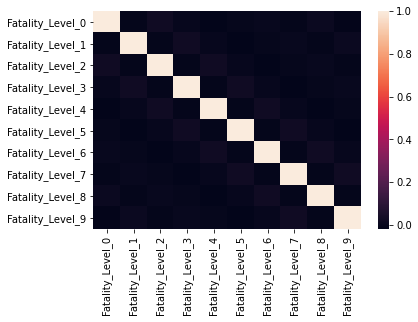

In [ ]:
data = dt.iloc[:,0:-1]

corr = data.corr()
sns.heatmap(corr)

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] < 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = data.columns[columns]
data = data[selected_columns]
data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning:

In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.



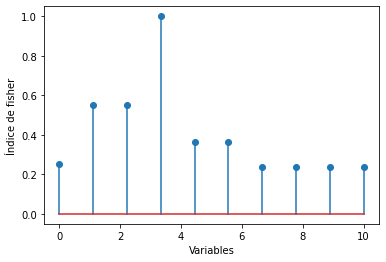

array([0.25258744, 0.54869113, 0.54869113, 1.        , 0.36471827,
       0.36471827, 0.23636932, 0.23636932, 0.23636932, 0.23636932])

In [ ]:

def fisher_index(X, plot=True):
  Columns = X.shape[1]
  idxs =np.zeros(X.shape[1])
  j = 0
  for i in range(Columns):
    if_j = 0
    for k in range(Columns):
      if i == k:
        continue
      mean_i = np.mean(X[:,i])
      mean_k = np.mean(X[:,k])
      std_i = np.std(X[:,i])
      std_k = np.std(X[:,k])

      if_j += ((mean_i - mean_k)**2 )/(std_i**2 + std_k**2)
    idxs[j] = if_j
    j += 1

  idxs = idxs / np.max(idxs)
  
  if plot == True:
    x = np.array(np.linspace(0, Columns, Columns))
    y = idxs
    plt.stem(x, y)
    plt.xlabel('Variables')
    plt.ylabel('Índice de fisher')
    plt.show()    
  return idxs
fisher_index(X)

# Selección de características por método de búsqueda secuencial ascendente o descendente 

In [ ]:
idx = 0
svc = SVC(kernel="rbf", gamma=0.001, C=4)
sfs = SequentialFeatureSelector(svc, forward=True, k_features=(2,10), floating=False, scoring="accuracy", cv=4, n_jobs=-1)

sfs = sfs.fit(X,y)

resultados_DF = pd.DataFrame.from_dict(sfs.get_metric_dict()).T


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [ ]:
resultados_DF

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(0,)","[0.7201520912547529, 0.7201520912547529, 0.720...",0.720236,"(0,)",0.000451729,0.000281806,0.000162701
2,"(0, 1)","[0.7201520912547529, 0.7201520912547529, 0.720...",0.720236,"(0, 1)",0.000451729,0.000281806,0.000162701
3,"(0, 1, 9)","[0.7186311787072244, 0.7209125475285171, 0.721...",0.720617,"(0, 1, 9)",0.00187215,0.00116792,0.000674298
4,"(0, 1, 5, 9)","[0.7178707224334601, 0.7193916349809886, 0.720...",0.719475,"(0, 1, 5, 9)",0.00166144,0.00103647,0.000598405
5,"(0, 1, 4, 5, 9)","[0.7133079847908745, 0.7163498098859316, 0.713...",0.712818,"(0, 1, 4, 5, 9)",0.00447901,0.00279417,0.00161322
6,"(0, 1, 4, 5, 6, 9)","[0.6965779467680608, 0.711787072243346, 0.7070...",0.70426,"(0, 1, 4, 5, 6, 9)",0.00913392,0.00569808,0.00328979
7,"(0, 1, 2, 4, 5, 6, 9)","[0.685171102661597, 0.6920152091254753, 0.6925...",0.691899,"(0, 1, 2, 4, 5, 6, 9)",0.00722825,0.00450925,0.00260342
8,"(0, 1, 2, 4, 5, 6, 7, 9)","[0.6790874524714829, 0.6684410646387833, 0.675...",0.678397,"(0, 1, 2, 4, 5, 6, 7, 9)",0.0131751,0.0082191,0.0047453
9,"(0, 1, 2, 3, 4, 5, 6, 7, 9)","[0.6973384030418252, 0.6631178707224334, 0.687...",0.686004,"(0, 1, 2, 3, 4, 5, 6, 7, 9)",0.0219196,0.0136743,0.00789486
10,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)","[0.6836501901140685, 0.6707224334600761, 0.684...",0.6822,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",0.0111794,0.00697416,0.00402653


A continuación veremos los 3 mejores modelos usando las mejores caracteristicas seleccionadas

In [19]:
new_dt = dt[["Fatality_Level_0","Fatality_Level_1","Fatality_Level_9","Fatality_Level"]]

# #cargamos la base de datos
X_new, y_new = new_dt[[i for i in new_dt.columns if i!="Fatality_Level"]].values, new_dt.Fatality_Level.values
y_new = (y_new>X_new[:,:].mean(axis=1)).astype(int)

QDA luego de selección

In [20]:
params_reg=[0.001,0.01,0.1,0.2,0.3,0.4,0.5,1]
tol=[1]
experimentarQDA_BestFeatures_DF, _ = experimentarQDA(X_new, y_new, params_reg, tol)
experimentarQDA_BestFeatures_DF

,param_reg,tol,error/eficiencia de entrenamiento,desviacion estandar entrenamiento,error/eficiencia de prueba,desviacion estandar prueba,accurancy real,precision score,recall score,f1 score
0,0.001,1.0,0.725307,0.005271,0.723662,0.008105,0.725307,0.793185,0.648420,0.711206
1,0.010,1.0,0.725561,0.005019,0.723662,0.007906,0.725561,0.792841,0.648781,0.711321
2,0.100,1.0,0.727526,0.004969,0.726515,0.009671,0.727526,0.792038,0.657075,0.715974
3,0.200,1.0,0.731457,0.004422,0.731840,0.010916,0.731457,0.789683,0.673297,0.725171
4,0.300,1.0,0.734056,0.004272,0.732791,0.010054,0.734056,0.787112,0.679427,0.727748
5,0.400,1.0,0.738240,0.004694,0.736975,0.010642,0.738240,0.786177,0.692048,0.734384
6,0.500,1.0,0.741790,0.004506,0.740969,0.011192,0.741790,0.785903,0.702866,0.740456
7,1.000,1.0,0.728540,0.003689,0.726705,0.007834,0.728540,0.790931,0.659239,0.716864


GBT luego de selección


In [21]:
num_trees= [5,10,20,50,100,200,500,1000,2000,5000]

experimentar_gbt_BestFeatures_DF, _ = experimentar_gbt(num_trees, X_new, y_new)
experimentar_gbt_BestFeatures_DF

,número de arboles,error/eficiencia de entrenamiento,desviacion estandar entrenamiento,error/eficiencia de prueba,desviacion estandar prueba,accurancy real,precision score,recall score,f1 score
0,5.0,0.832192,0.008409,0.830158,0.026004,0.832192,0.758848,0.996032,0.861178
1,10.0,0.832192,0.008319,0.829208,0.024270,0.832192,0.759032,0.993149,0.860161
2,20.0,0.832762,0.008362,0.829589,0.023964,0.832762,0.759603,0.992789,0.860387
3,50.0,0.834030,0.008822,0.828258,0.022599,0.834030,0.759970,0.988464,0.858919
4,100.0,0.838658,0.007784,0.827877,0.022538,0.838658,0.761084,0.984134,0.858078
5,200.0,0.849182,0.005893,0.824073,0.021288,0.849182,0.760812,0.974399,0.854145
6,500.0,0.874857,0.005958,0.812662,0.020226,0.874857,0.760466,0.943746,0.841905
7,1000.0,0.902624,0.003712,0.798207,0.020652,0.902624,0.759772,0.905157,0.825780
8,2000.0,0.925130,0.003736,0.786986,0.019612,0.925130,0.759408,0.874504,0.812622
9,5000.0,0.932991,0.004397,0.778237,0.016565,0.932991,0.759405,0.850346,0.801916


SVC luego de selección


In [23]:
kernels=['linear', 'rbf']
gammas = [0.01,0.1]
params_reg = [0.001, 0.01,0.1, 1.0,10]

experiementarSVC_BestFeatures_DF, mejorSVC = experiementarSVC(X_new, y_new, kernels, gammas,params_reg)
experiementarSVC_BestFeatures_DF

parametros usados ('linear', 0.01, 0.001)
parametros usados ('linear', 0.01, 0.01)
parametros usados ('linear', 0.01, 0.1)
parametros usados ('linear', 0.01, 1.0)
parametros usados ('linear', 0.01, 10)
parametros usados ('linear', 0.1, 0.001)
parametros usados ('linear', 0.1, 0.01)
parametros usados ('linear', 0.1, 0.1)
parametros usados ('linear', 0.1, 1.0)
parametros usados ('linear', 0.1, 10)
parametros usados ('rbf', 0.01, 0.001)
parametros usados ('rbf', 0.01, 0.01)
parametros usados ('rbf', 0.01, 0.1)
parametros usados ('rbf', 0.01, 1.0)
parametros usados ('rbf', 0.01, 10)
parametros usados ('rbf', 0.1, 0.001)
parametros usados ('rbf', 0.1, 0.01)
parametros usados ('rbf', 0.1, 0.1)
parametros usados ('rbf', 0.1, 1.0)
parametros usados ('rbf', 0.1, 10)


,kernel,gamma,param_reg,% de vectores de soporte,error/eficiencia de entrenamiento,desviacion estandar entrenamiento,error/eficiencia de prueba,desviacion estandar prueba,accurancy real,precision score,recall score,f1 score
0,linear,0.01,0.001,55.090677,0.749144,0.009344,0.745153,0.011843,0.749144,0.783242,0.718013,0.747561
1,linear,0.01,0.010,55.058979,0.748763,0.009012,0.744963,0.012171,0.748763,0.783148,0.717653,0.747316
2,linear,0.01,0.100,55.109702,0.748827,0.009161,0.745533,0.011609,0.748827,0.783406,0.718734,0.748076
3,linear,0.01,1.000,54.672262,0.748193,0.008452,0.743821,0.011928,0.748193,0.782623,0.715488,0.745976
4,linear,0.01,10.000,46.316781,0.721059,0.006648,0.718339,0.013372,0.721059,0.792180,0.637253,0.702581
5,linear,0.10,0.001,55.090677,0.749144,0.009344,0.745153,0.011843,0.749144,0.783242,0.718013,0.747561
6,linear,0.10,0.010,55.058979,0.748763,0.009012,0.744963,0.012171,0.748763,0.783148,0.717653,0.747316
7,linear,0.10,0.100,55.109702,0.748827,0.009161,0.745533,0.011609,0.748827,0.783406,0.718734,0.748076
8,linear,0.10,1.000,54.672262,0.748193,0.008452,0.743821,0.011928,0.748193,0.782623,0.715488,0.745976
9,linear,0.10,10.000,46.316781,0.721059,0.006648,0.718339,0.013372,0.721059,0.792180,0.637253,0.702581


# Extracción de características por el método PCA


In [ ]:
def entrenamiento_sin_seleccion_caracteristicas(splits, X, Y):
    """
    Función que ejecuta el entrenamiento del modelo sin una selección particular
    de las características

      Parámetros:splits : numero de particiones  a realizar
      Retorna:
      1. El modelo entreando
      2. El vector de errores
      3. El Intervalo de confianza
      4. El tiempo de procesamiento
    """
    Errores = np.ones(splits)
    Score = np.ones(splits)
    times = np.ones(splits)
    j = 0
    kf = KFold(n_splits=splits)
    for train_index, test_index in kf.split(X):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        clf = SVC(kernel="rbf", C=1)
        
        tiempo_i = time.time()
        clf.fit(x_train,y_train)
        # Validación del modelo
        Errores[j] = accuracy_score(y_true=y_test, y_pred=clf.predict(x_test))
        times[j] = time.time()-tiempo_i
        j+=1

    return np.mean(Errores), np.std(Errores), np.mean(times)

def entrenamiento_pca_ext_caracteristicas(n_comp, X, Y):
    """
    Esta función realiza la reducción de la dimensionalidad sobre el conjunto de
    datos de entrenamiento, de acuerdo con las particiones especificadas usando PCA

    Parámetros:
    n_comp, int, Número de componentes para reducción
    n_sets,int, Número de particiones
    X: numpy Array de características
    Y: numpy Array  Vector de etiquetas

    Retorna: 
    ErrorValidacion: El valor medio de errores
    IC_Validacion: Intervalo de confianza
    T_ejec:  El  valor medio del tiempo de ejecución
    """ 
    Errores = np.ones(4)
    times = np.ones(4)
    j = 0
    kf = KFold(n_splits=4)
    for train_index, test_index in kf.split(X):  
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        #dejar el mismo nombre del objeto 
        pca = PCA(n_components=n_comp)
        # para calcular costo computacional
        tiempo_i = time.time()
        # es recomendable usar el metodo que ajusta y transforma
        x_train_pca = pca.fit_transform(X=x_train)
        x_test_pca = pca.transform(X=x_test)
        # entrenar el modelo usando las caractieristicas transformadas por PCA
        print("running SVC",n_comp,j)
        clf = SVC(kernel="rbf", C=1)
        clf.fit(X=x_train_pca, y=y_train)
        tiempo_o = time.time()-tiempo_i
        Errores[j] = accuracy_score(y_true=y_test, y_pred=clf.predict(x_test_pca))
        times[j] = tiempo_o
        j+=1


    return np.mean(Errores), np.std(Errores), np.mean(times)


def experimentar_PCA(n_feats, X, Y):
    """
    Esta función realiza la comparación del desempeño de RFE utilizando diferente 
    número de feats y particionando el conjunto de datos en diferente número de 
    subconjuntos

    Parámetros:
    X (numpy.array), El arreglo numpy de características
    Y (numpy.array), El vector de etiquetas
    n_feats, Vector de números enteros que indica el número de características
              que debe utilizar el modelo
    n_sets, Vector de números enteros que indica el número de particiones

    Retorna:  
    - DataFrame con las columnas: CON_SEL, NUM_VAR, ERROR_VALIDACION, IC_STD_VALIDACION, 
    y T_EJECUCION. 

    """
    df = pd.DataFrame()
    idx = 0
    split_number = 4
    #Sin selección de características
    error,ic_error,t_ex = entrenamiento_sin_seleccion_caracteristicas(split_number, X,Y)  
    df.loc[idx,'CON_SEL'] = 'NO'
    df.loc[idx,'NUM_VAR'] = X.shape[1] # se usan todas las caracteristicas
    df.loc[idx,'ERROR_VALIDACION'] = error
    df.loc[idx,'IC_STD_VALIDACION'] = ic_error
    df.loc[idx,'T_EJECUCION'] = t_ex
    idx+=1
    print("termina experimento sin selección")
    #Con selección de características
    for f in n_feats:
        #Implemetamos la metodología de validación 
        error, ic_error, t_ex = entrenamiento_pca_ext_caracteristicas(n_comp=f, X=X,Y=Y)
        df.loc[idx,'CON_SEL'] = 'SI'
        df.loc[idx,'NUM_VAR'] = f
        df.loc[idx,'ERROR_VALIDACION'] = error
        df.loc[idx, 'IC_STD_VALIDACION'] = ic_error
        df.loc[idx, 'T_EJECUCION'] = t_ex
        idx+=1
    return df

In [ ]:
experimentar_PCA(n_feats=[1,3,5,8,10], X= X, Y = y)

termina experimento sin selección
running SVC 1 0
running SVC 1 1
running SVC 1 2
running SVC 1 3
running SVC 3 0
running SVC 3 1
running SVC 3 2
running SVC 3 3
running SVC 5 0
running SVC 5 1
running SVC 5 2
running SVC 5 3
running SVC 8 0
running SVC 8 1
running SVC 8 2
running SVC 8 3
running SVC 10 0
running SVC 10 1
running SVC 10 2
running SVC 10 3


,CON_SEL,NUM_VAR,ERROR_VALIDACION,IC_STD_VALIDACION,T_EJECUCION
0,NO,10.0,0.720234,0.004372,1.069141
1,SI,1.0,0.721566,0.004192,0.565665
2,SI,3.0,0.720234,0.004372,1.369433
3,SI,5.0,0.720234,0.004372,1.198888
4,SI,8.0,0.720425,0.004271,1.020133
5,SI,10.0,0.720234,0.004372,0.996549
